# Streaming - Webcam Example


### Post-processing goals
- Analysis done in weeks instead of months
- Some real-time analysis and statistics

### Streaming
Can handle static data or live data coming in from a 'streaming' device like a camera to do real-time analysis.
The exact same code can be used for real-time analysis and static code

### Scalability

#### Connect more computers. 
#### Start workers on these computer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.io import imread, imsave


class WebcamFeed:
    def __init__(self):
        try:
            import cv2
            self.cap = cv2.VideoCapture(0)
            self.read_func = lambda: self.cap.read()[1][:, :, ::-1]
        except Exception as e:
            print(e)
            self.cap = None
            self.read_func = lambda: imread('../common/data/face.jpg')

    def read_frame(self):
        return self.read_func()

    def close(self):
        if self.cap is not None:
            self.cap.release()
            self.cap = None

Setup the distributed code for running the streaming tasks

In [2]:
from dask.distributed import Client
client = Client(processes=False)  # start local workers as threads

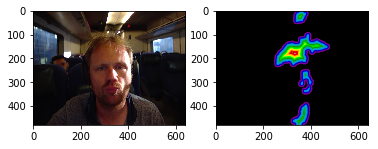

In [3]:
from skimage.filters import threshold_otsu
from skimage.morphology import label, binary_opening, disk
from scipy.ndimage import distance_transform_bf
from skimage.color import rgb2hsv


def process_image(in_frame):
    gray = rgb2hsv(np.clip(in_frame, 1, 255))
    gray = (gray[:, :, 0] < 0.2)*gray[:, :, 2]
    thresh = gray > threshold_otsu(gray)

    clean = binary_opening(thresh, disk(15))
    all_labels = label(clean).astype(np.uint16)

    lab_ids = sorted(np.unique(all_labels[all_labels > 0]),
                     key=lambda x: -np.sum(all_labels == x))
    new_labels = np.zeros_like(all_labels)

    for i, j in zip(range(4), lab_ids):
        new_labels[all_labels == j] = 1
    return distance_transform_bf(new_labels > 0)


fig, (ax1, ax2) = plt.subplots(1, 2)
test_img = imread('../common/data/face.jpg')
ax1.imshow(test_img)
ax2.imshow(process_image(test_img), cmap='nipy_spectral')

In [4]:
client.submit(process_image, test_img)

<Future: status: pending, key: process_image-d0283e950ce5b399e4daa99395f52678>

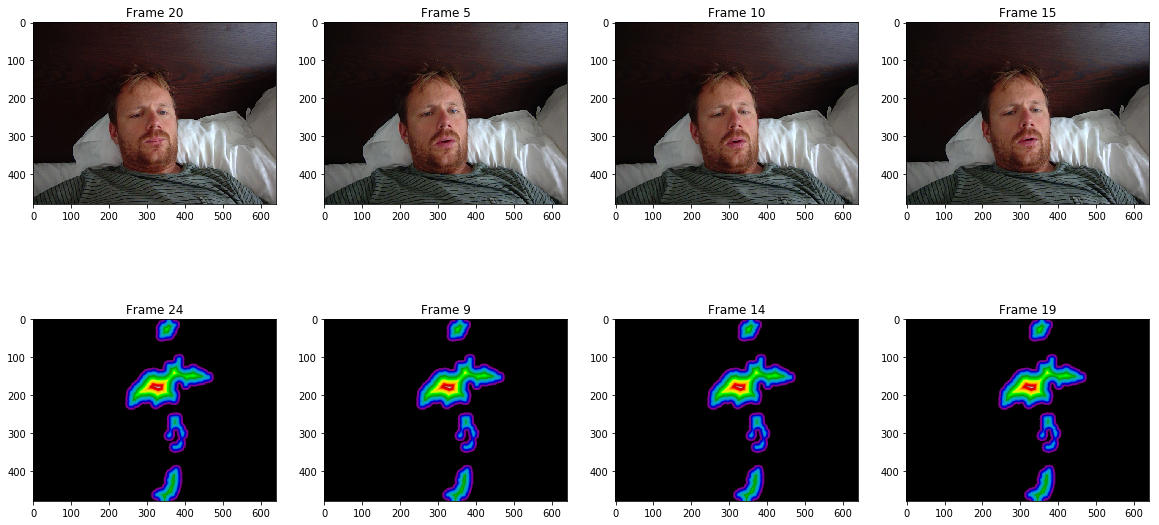

In [5]:
from IPython.display import clear_output, update_display
from itertools import cycle

my_webcam = WebcamFeed()
fig, (m_ax_in, m_ax_proc) = plt.subplots(2, 4, figsize=(20, 10))
display(fig, display_id='preview_figure')
out_images = []
frames_per_loop = 5
for i, ax_in, ax_proc in zip(range(5), cycle(m_ax_in), cycle(m_ax_proc)):

    for j in range(frames_per_loop):
        c_frame = my_webcam.read_frame()
        out_images += [client.submit(process_image, test_img)]
    ax_in.imshow(c_frame)
    ax_in.set_title('Frame {}'.format(i*frames_per_loop))
    comp_list = [(x, j) for j, x in enumerate(out_images) if x.done()]
    if len(comp_list) > 0:
        p_img, p_idx = comp_list[-1]
        ax_proc.imshow(p_img.result(), cmap='nipy_spectral')
        ax_proc.set_title('Frame {}'.format(p_idx))
    update_display(obj=fig, display_id='preview_figure')

clear_output()
my_webcam.close()

In [6]:
client.futures

{'process_image-d0283e950ce5b399e4daa99395f52678': <FutureState: finished>}

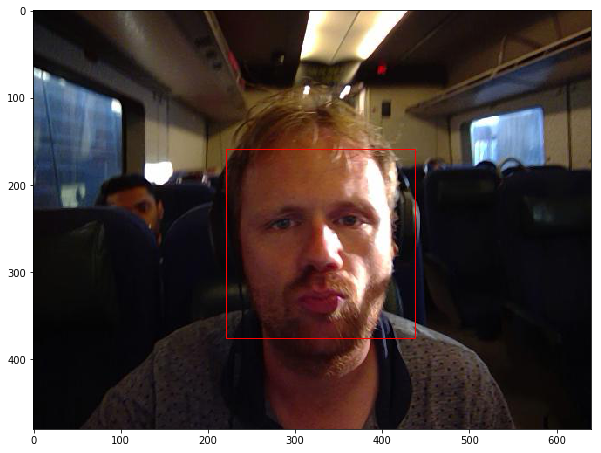

In [14]:
import matplotlib.patches as patches

def detect_faces(raw_img):
    import cv2
    img = raw_img[:, :, ::-1]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(
        'haar_face.xml')
    return face_cascade.detectMultiScale(gray, 1.3, 5)


try:
    fig, ax1 = plt.subplots(1,1, figsize = (10, 10))
    plt.imshow(test_img)
    faces = detect_faces(test_img)
    for (x, y, w, h) in faces:
        rect = patches.Rectangle((x, y), w, h, linewidth=1,
                         edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax1.add_patch(rect)
        
except Exception as e:
    print('OpenCV not setup correctly!', e)